# Iceberg Figures for Cosine and Retrieval
Make tables related to the performance of ICEBERG on cosine similarity

In [1]:
import pandas as pd
import numpy as np
import yaml
from ms_pred.common.plot_utils import *
from pathlib import Path
import matplotlib

from collections import defaultdict
from scipy.stats import sem

set_style()

In [2]:
%cd ~/ms-pred

/mnt/home/runzhong/ms-pred


In [3]:
dataset_names = ["nist20"]

# Define
results_folder = Path("results/figs_iceberg/weave_acc/")

results_folder.mkdir(exist_ok=True, parents=True)

In [4]:
a = pd.read_csv(f"results/graff_ms_baseline_nist20/split_1_rnd1/preds/pred_eval_grouped_ion_type.tsv", sep='\t')
b = pd.read_csv(f"results/graff_ms_baseline_nist20/split_1_rnd1/retrieval_nist20_split_1_50/rerank_eval_grouped_ion_cos.tsv", sep='\t')
pd.concat((a, None), axis=1).columns

Index(['Unnamed: 0', 'cos_sim', 'cos_sim_zero_pep', 'mse', 'entropy_sim',
       'frac_valid', 'overlap_coeff', 'coverage', 'len_targ', 'len_pred',
       'compound_mass', 'num_examples'],
      dtype='object')

In [5]:
def weighted_group_average(inp_df):
    # rm the current "avg" row
    df_filtered = inp_df[inp_df.iloc[:, 0] != 'avg']

    # Filter positive and negative rows
    positive_rows = df_filtered[df_filtered.iloc[:, 0].str.endswith('+')]
    negative_rows = df_filtered[df_filtered.iloc[:, 0].str.endswith('-')]
    metfrag_rows = df_filtered[df_filtered.iloc[:, 0].str.endswith(('[M+H]+', '[M-H]-', '[M+Na]+', '[M+K]+', '[M+Cl]-', '[M+H3N+H]+'))]

    def weighted_avg(df):
        weights = df['num_examples']
        result = {}
        for col in df.select_dtypes(include=[np.number]).columns:
            result[col] = np.average(df[col], weights=weights)
        return result
    
    # List of all original columns
    columns = inp_df.columns

    # Create new row dictionaries and include labels for 'Unnamed: 0'
    def create_row_dict(weighted_dict, label, all_columns):
        # For each column in the original DataFrame, use the weighted value if available, otherwise NaN.
        row = {col: weighted_dict[col] if col in weighted_dict else np.nan for col in all_columns}
        row[columns[0]] = label
        return row

    
    # Calculate weighted averages for each group and create new rows
    # 6, 3/4, 9/10 are the current experiment setup (scaffold split does not have [M-H-CO2]- in test set)
    weighted_df = []
    if len(positive_rows) == 6:
        weighted_avg_positive = weighted_avg(positive_rows)
        wp_row = create_row_dict(weighted_avg_positive, 'pos_avg', columns)
        weighted_df.append(wp_row)
    if len(negative_rows) == 3 or len(negative_rows) == 4: 
        weighted_avg_negative = weighted_avg(negative_rows)
        wn_row = create_row_dict(weighted_avg_negative, 'neg_avg', columns)
        weighted_df.append(wn_row)
    if len(df_filtered) == 9 or len(df_filtered) == 10:
        weighted_avg_general  = weighted_avg(df_filtered)
        wg_row = create_row_dict(weighted_avg_general,  'avg',  columns)
        weighted_df.append(wg_row)
    if len(metfrag_rows) == 6:
        weighted_avg_metfrag  = weighted_avg(metfrag_rows)
        mf_row = create_row_dict(weighted_avg_metfrag,  'metfrag',  columns)
        weighted_df.append(mf_row)

    # Create a DataFrame for these new rows
    weighted_df = pd.DataFrame(weighted_df)

    # Concatenate the new rows with the original DataFrame
    out_df = pd.concat([df_filtered, weighted_df], ignore_index=True)
    
    return out_df

In [6]:
names = [
    "CFM-ID",
    "MetFrag",
    "GrAFF-MS",
    "MassFormer",
    "FraGNNet",
    "ICEBERG (Goldman'24)",
    "ICEBERG (Ours)",
]

all_adducts = ['[M+H]+', '[M-H2O+H]+', '[M-H4O2+H]+', '[M+Na]+', '[M+K]+', '[M+H3N+H]+', # pos
               '[M-H]-', '[M+Cl]-', '[M-H-H2O]-', '[M-H-CO2]-'] # neg

dataset_to_res = {}
for dataset_name in dataset_names:
    for split_name in ['split_1', 'scaffold_1']:
        tsv_files = defaultdict(lambda : [])
        for seed in [1,2,3]:    
            results_files = [
                f"results/cfm_id_{dataset_name}/{split_name}/preds/pred_eval_grouped_ion_type.tsv",
                None,
                f"results/graff_ms_baseline_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"results/massformer_baseline_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"results/fragnet_preprint_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"../ms-pred-legacy/results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv", # old ICEBERG (with Analy Chem'24)
                f"results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
            ]
            for i, j in zip(names, results_files):
                if j and Path(j).exists():
                    cos_df = pd.read_csv(j, sep='\t')
                else:
                    cos_df = None
                if j:
                    retrieval_path_entr = Path(j).parent / f'../retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_ion_entropy.tsv'
                    retrieval_path_cos = Path(j).parent / f'../retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_ion_cos.tsv'
                    if retrieval_path_entr.exists():
                        retrieval_df = pd.read_csv(retrieval_path_entr, sep='\t')
                    elif retrieval_path_cos.exists():
                        retrieval_df = pd.read_csv(retrieval_path_cos, sep='\t')
                    else:
                        retrieval_df = None
                elif i == 'MetFrag':
                    retrieval_path = f'results/metfrag_{dataset_name}/{split_name}/retrieval/rerank_eval_grouped_ion_met_frag.tsv'
                    retrieval_df = pd.read_csv(retrieval_path, sep='\t')
                else:
                    retrieval_df = None

                if cos_df is not None:
                    cos_df = weighted_group_average(cos_df)
                if retrieval_df is not None:
                    retrieval_df = weighted_group_average(retrieval_df)
                
                concat_df = pd.concat((cos_df, retrieval_df), axis=1)
                tsv_files[i].append(concat_df)

        dataset_to_res[f"{split_name}_{dataset_name}"] = tsv_files

In [7]:
adduct_to_df = {}
for adduct_type in all_adducts + ['pos_avg', 'neg_avg', 'avg', 'metfrag']:
    out_df = []
    for dataset_name, tsv_files in dataset_to_res.items():
        for k, v in tsv_files.items():
            interested_rows = [vv[vv.iloc[:, 0] == adduct_type] for vv in v]
            if any([len(row) == 0 for row in interested_rows]):
                continue
            def get_val(key):
                vals = []
                for row in interested_rows:
                    if key in row:
                        vals.append(row[key].item())
                return vals
            new_entry = {
                "Method": k,
                "Cosine sim.": np.mean(get_val('cos_sim')),
                "Cosine sim. 95%": 1.96 * sem(get_val('cos_sim')),

                "Cosine sim. (no PEP)": np.mean(get_val('cos_sim_zero_pep')),
                "Cosine sim. 95% (no PEP)": 1.96 * sem(get_val('cos_sim_zero_pep')),

                "Entropy sim.": np.mean(get_val('entropy_sim')),
                "Entropy sim. 95%": 1.96 * sem(get_val('entropy_sim')),

                "Coverage": np.mean(get_val('coverage')),
                "Coverage 95%": 1.96 * sem(get_val('coverage')),

                # The way of computing validity in this code base is outdated
                #"Valid": np.mean(get_val('frac_valid')),
                #"Valid 95%": 1.96 * sem(get_val('frac_valid')),

                "Dataset": dataset_name,
            }
            new_entry.update({
                f"Top_{i} Retrieval": np.mean(get_val(f"top_{i}")) for i in range(1, 11)
            })
            new_entry.update({
                f"Top_{i} Retrieval 95%": 1.96 * sem(get_val(f"top_{i}")) for i in range(1, 11)
            })
            out_df.append(new_entry)
    out_df = pd.DataFrame(out_df)

    # Replace nan with 0 
    out_df = out_df.fillna(0)
    
    adduct_to_df[adduct_type] = out_df


/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
for adduct_type, out_df in adduct_to_df.items():
    # rewrite cosine sim column with f"cos sim \pm cosine sem using list comprehension
    out_df["Cosine sim. orig"] = out_df["Cosine sim."] 

    out_df["Cosine sim."] = [
        rf"${i:.3f} \pm {j:.3f}$"
        for i, j in zip(out_df["Cosine sim."], out_df["Cosine sim. 95%"])
    ]
    # Same for entropy
    out_df["Entropy sim."] = [
        rf"${i:.3f} \pm {j:.3f}$"
        for i, j in zip(out_df["Entropy sim."], out_df["Entropy sim. 95%"])
    ]
    # Rewrite coverage column with f"coverage \pm coverage sem using list comprehension
    out_df["Coverage"] = [
        rf"${i:.3f} \pm {j:.3f}$"
        for i, j in zip(out_df["Coverage"], out_df["Coverage 95%"])
    ]
    # Rewrite all top_K retrieval accuracy columns
    for i in range(1, 11):
    #     out_df[f"Top_{i} Retrieval orig"] = out_df[f"Top_{i} Retrieval"]
        out_df[f"Top-{i}"] = [
            rf"${i:.3f} \pm {j:.3f}$"
            for i, j in zip(out_df[f"Top_{i} Retrieval"], out_df[f"Top_{i} Retrieval 95%"])
        ]

In [9]:
# select adduct type to process and report
active_adduct = '[M+H]+'  # [M+H]+ / [M-H]- / pos_avg / neg_avg / avg / metfrag
out_df = adduct_to_df[active_adduct]

# Update names
names = list(out_df['Method'].unique())

out_df

,Method,Cosine sim.,Cosine sim. 95%,Cosine sim. (no PEP),Cosine sim. 95% (no PEP),Entropy sim.,Entropy sim. 95%,Coverage,Coverage 95%,Dataset,...,Top-1,Top-2,Top-3,Top-4,Top-5,Top-6,Top-7,Top-8,Top-9,Top-10
0,CFM-ID,$0.470 \pm 0.000$,7.693453e-17,0.470696,0.000000,$0.427 \pm 0.000$,0.000000,$0.261 \pm 0.000$,0.000000e+00,split_1_nist20,...,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$
1,MetFrag,$0.000 \pm 0.000$,0.000000e+00,0.000000,0.000000,$0.000 \pm 0.000$,0.000000,$0.000 \pm 0.000$,0.000000e+00,split_1_nist20,...,$0.107 \pm 0.000$,$0.193 \pm 0.000$,$0.267 \pm 0.000$,$0.317 \pm 0.000$,$0.375 \pm 0.000$,$0.414 \pm 0.000$,$0.457 \pm 0.000$,$0.497 \pm 0.000$,$0.537 \pm 0.000$,$0.567 \pm 0.000$
2,GrAFF-MS,$0.565 \pm 0.001$,1.389130e-03,0.565187,0.001389,$0.529 \pm 0.001$,0.001179,$0.740 \pm 0.001$,6.337984e-04,split_1_nist20,...,$0.211 \pm 0.004$,$0.365 \pm 0.009$,$0.472 \pm 0.015$,$0.551 \pm 0.013$,$0.608 \pm 0.005$,$0.655 \pm 0.006$,$0.690 \pm 0.004$,$0.724 \pm 0.008$,$0.754 \pm 0.010$,$0.776 \pm 0.009$
3,MassFormer,$0.632 \pm 0.001$,6.916828e-04,0.631474,0.000683,$0.605 \pm 0.000$,0.000103,$0.787 \pm 0.001$,7.162337e-04,split_1_nist20,...,$0.252 \pm 0.001$,$0.422 \pm 0.002$,$0.539 \pm 0.005$,$0.617 \pm 0.007$,$0.675 \pm 0.004$,$0.724 \pm 0.005$,$0.761 \pm 0.008$,$0.794 \pm 0.010$,$0.822 \pm 0.005$,$0.843 \pm 0.006$
4,FraGNNet,$0.717 \pm 0.001$,1.131607e-03,0.000000,0.000000,$0.000 \pm 0.000$,0.000000,$0.000 \pm 0.000$,0.000000e+00,split_1_nist20,...,$0.238 \pm 0.000$,$0.000 \pm 0.000$,$0.504 \pm 0.000$,$0.000 \pm 0.000$,$0.652 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.831 \pm 0.000$
5,ICEBERG (Goldman'24),$0.754 \pm 0.002$,1.706714e-03,0.720421,0.001994,$0.700 \pm 0.001$,0.000815,$0.809 \pm 0.001$,1.458599e-03,split_1_nist20,...,$0.251 \pm 0.016$,$0.454 \pm 0.004$,$0.576 \pm 0.006$,$0.654 \pm 0.004$,$0.711 \pm 0.007$,$0.753 \pm 0.007$,$0.783 \pm 0.005$,$0.810 \pm 0.001$,$0.833 \pm 0.007$,$0.850 \pm 0.009$
6,ICEBERG (Ours),$0.794 \pm 0.002$,2.195509e-03,0.793819,0.002199,$0.763 \pm 0.001$,0.001312,$0.856 \pm 0.000$,4.687100e-04,split_1_nist20,...,$0.400 \pm 0.008$,$0.611 \pm 0.013$,$0.721 \pm 0.010$,$0.790 \pm 0.007$,$0.829 \pm 0.006$,$0.859 \pm 0.005$,$0.881 \pm 0.006$,$0.900 \pm 0.009$,$0.913 \pm 0.008$,$0.923 \pm 0.007$
7,CFM-ID,$0.450 \pm 0.000$,0.000000e+00,0.450495,0.000000,$0.401 \pm 0.000$,0.000000,$0.228 \pm 0.000$,3.846727e-17,scaffold_1_nist20,...,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$
8,MetFrag,$0.000 \pm 0.000$,0.000000e+00,0.000000,0.000000,$0.000 \pm 0.000$,0.000000,$0.000 \pm 0.000$,0.000000e+00,scaffold_1_nist20,...,$0.127 \pm 0.000$,$0.225 \pm 0.000$,$0.302 \pm 0.000$,$0.363 \pm 0.000$,$0.420 \pm 0.000$,$0.471 \pm 0.000$,$0.510 \pm 0.000$,$0.548 \pm 0.000$,$0.582 \pm 0.000$,$0.612 \pm 0.000$
9,GrAFF-MS,$0.470 \pm 0.001$,1.248363e-03,0.470040,0.001293,$0.448 \pm 0.001$,0.000614,$0.706 \pm 0.001$,1.041536e-03,scaffold_1_nist20,...,$0.143 \pm 0.004$,$0.270 \pm 0.002$,$0.368 \pm 0.008$,$0.450 \pm 0.006$,$0.518 \pm 0.002$,$0.569 \pm 0.002$,$0.614 \pm 0.003$,$0.650 \pm 0.000$,$0.687 \pm 0.002$,$0.716 \pm 0.002$


In [10]:
# only build scaffold split and normal split for NIST

out_df_temp = out_df[out_df["Dataset"].isin(["split_1_nist20", "scaffold_1_nist20"])]
out_df_pivot = out_df_temp.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Cosine sim.",
        "Entropy sim."
    ],
    aggfunc=lambda x: x,
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = ["Cosine sim.", "Entropy sim."]
dataset_order = ["split_1_nist20", "scaffold_1_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]


# Sort columns and make time last

out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(
    caption="Comparing NIST scaffold vs. random spllit cosine similarity",
    label="tab:scaffold",
    escape=False,
)
print(latex)

# Output to file "nist_scaffold_cosine.txt" in result folder
with open(results_folder / "nist_scaffold_cosine.txt", "w") as f:
    f.write(latex)

\begin{table}
\caption{Comparing NIST scaffold vs. random spllit cosine similarity}
\label{tab:scaffold}
\begin{tabular}{lllll}
\toprule
Dataset & \multicolumn{2}{r}{split_1_nist20} & \multicolumn{2}{r}{scaffold_1_nist20} \\
 & Cosine sim. & Entropy sim. & Cosine sim. & Entropy sim. \\
\midrule
CFM-ID & $0.470 \pm 0.000$ & $0.427 \pm 0.000$ & $0.450 \pm 0.000$ & $0.401 \pm 0.000$ \\
MetFrag & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ \\
GrAFF-MS & $0.565 \pm 0.001$ & $0.529 \pm 0.001$ & $0.470 \pm 0.001$ & $0.448 \pm 0.001$ \\
MassFormer & $0.632 \pm 0.001$ & $0.605 \pm 0.000$ & $0.526 \pm 0.002$ & $0.512 \pm 0.002$ \\
FraGNNet & $0.717 \pm 0.001$ & $0.000 \pm 0.000$ & $0.654 \pm 0.003$ & $0.000 \pm 0.000$ \\
ICEBERG (Goldman'24) & $0.754 \pm 0.002$ & $0.700 \pm 0.001$ & $0.701 \pm 0.001$ & $0.641 \pm 0.004$ \\
ICEBERG (Ours) & $0.794 \pm 0.002$ & $0.763 \pm 0.001$ & $0.735 \pm 0.000$ & $0.708 \pm 0.000$ \\
\bottomrule
\end{tabular}
\end{table}



In [11]:
out_df_pivot = out_df.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Cosine sim.",
        "Coverage",
        "Entropy sim.",
    ],
    aggfunc=lambda x: x,
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)


metric_order = {"Cosine sim.": 1, "Entropy sim.": 2, "Coverage": 3}
metric_order = ["Cosine sim.", "Entropy sim.", "Coverage"]
dataset_order = {"split_1_nist20": 1, "scaffold_1_nist20": 2}
dataset_order = ["split_1_nist20", "scaffold_1_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(
    caption="Spectra prediction accuracy", label="tab:spec_acc", escape=False
)
print(latex)


# Output to file "all_cosine.txt" in result folder
with open(results_folder / "all_cosine.txt", "w") as f:
    f.write(latex)

\begin{table}
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lllllll}
\toprule
Dataset & \multicolumn{3}{r}{split_1_nist20} & \multicolumn{3}{r}{scaffold_1_nist20} \\
 & Cosine sim. & Entropy sim. & Coverage & Cosine sim. & Entropy sim. & Coverage \\
\midrule
CFM-ID & $0.470 \pm 0.000$ & $0.427 \pm 0.000$ & $0.261 \pm 0.000$ & $0.450 \pm 0.000$ & $0.401 \pm 0.000$ & $0.228 \pm 0.000$ \\
MetFrag & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ \\
GrAFF-MS & $0.565 \pm 0.001$ & $0.529 \pm 0.001$ & $0.740 \pm 0.001$ & $0.470 \pm 0.001$ & $0.448 \pm 0.001$ & $0.706 \pm 0.001$ \\
MassFormer & $0.632 \pm 0.001$ & $0.605 \pm 0.000$ & $0.787 \pm 0.001$ & $0.526 \pm 0.002$ & $0.512 \pm 0.002$ & $0.742 \pm 0.002$ \\
FraGNNet & $0.717 \pm 0.001$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.654 \pm 0.003$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ \\
ICEBERG (Goldman'24) & $0.754 \pm 0.002$ & $0.700 \pm

In [12]:
out_df_pivot = out_df.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Top-1",
        "Top-2",
        "Top-3",
        "Top-4",
        "Top-5",
        "Top-6",
        "Top-7",
        "Top-8",
        "Top-9",
        "Top-10",
    ],
    aggfunc=lambda x: x,
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = [f"Top-{i}" for i in range(1, 11)]
dataset_order = ["split_1_nist20"]  # random split

new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_random = out_df_pivot_sorted.loc[:, new_index]

out_df_pivot_random.index.name = None
latex = out_df_pivot_random.to_latex(
    caption="Retrieval accuracy accuracy", label="tab:retrieval_acc", escape=False
)
print(latex)

dataset_order = ["scaffold_1_nist20"]  # scaffold split
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_scaffold = out_df_pivot_sorted.loc[:, new_index]

# Sort columns and make time last
out_df_pivot_scaffold.index.name = None
latex = out_df_pivot_scaffold.to_latex(
    caption="Retrieval accuracy accuracy", label="tab:retrieval_acc", escape=False
)
print(latex)


\begin{table}
\caption{Retrieval accuracy accuracy}
\label{tab:retrieval_acc}
\begin{tabular}{lllllllllll}
\toprule
Dataset & \multicolumn{10}{r}{split_1_nist20} \\
 & Top-1 & Top-2 & Top-3 & Top-4 & Top-5 & Top-6 & Top-7 & Top-8 & Top-9 & Top-10 \\
\midrule
CFM-ID & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ \\
MetFrag & $0.107 \pm 0.000$ & $0.193 \pm 0.000$ & $0.267 \pm 0.000$ & $0.317 \pm 0.000$ & $0.375 \pm 0.000$ & $0.414 \pm 0.000$ & $0.457 \pm 0.000$ & $0.497 \pm 0.000$ & $0.537 \pm 0.000$ & $0.567 \pm 0.000$ \\
GrAFF-MS & $0.211 \pm 0.004$ & $0.365 \pm 0.009$ & $0.472 \pm 0.015$ & $0.551 \pm 0.013$ & $0.608 \pm 0.005$ & $0.655 \pm 0.006$ & $0.690 \pm 0.004$ & $0.724 \pm 0.008$ & $0.754 \pm 0.010$ & $0.776 \pm 0.009$ \\
MassFormer & $0.252 \pm 0.001$ & $0.422 \pm 0.002$ & $0.539 \pm 0.005$ & $0.617 \pm 0.007$ & $0.675 \pm 0.00

In [13]:
method_colors

{'CFM-ID': '#D7D7D7',
 'MassFormer': '#E9B382',
 'GrAFF-MS': '#FFD593',
 'FraGNNet': '#7C9D97',
 "ICEBERG (Goldman'24)": '#A7B7C3',
 'ICEBERG (Ours)': '#7B94CC',
 'MetFrag': '#818181'}

/tmp/ipykernel_1430101/575365818.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.array(method_names)[valid_indices], rotation=45, ha="right")


[Text(0, 0, 'CFM-ID'),
 Text(1, 0, 'GrAFF-MS'),
 Text(2, 0, 'MassFormer'),
 Text(3, 0, 'FraGNNet'),
 Text(4, 0, "ICEBERG (Goldman'24)"),
 Text(5, 0, 'ICEBERG (Ours)')]

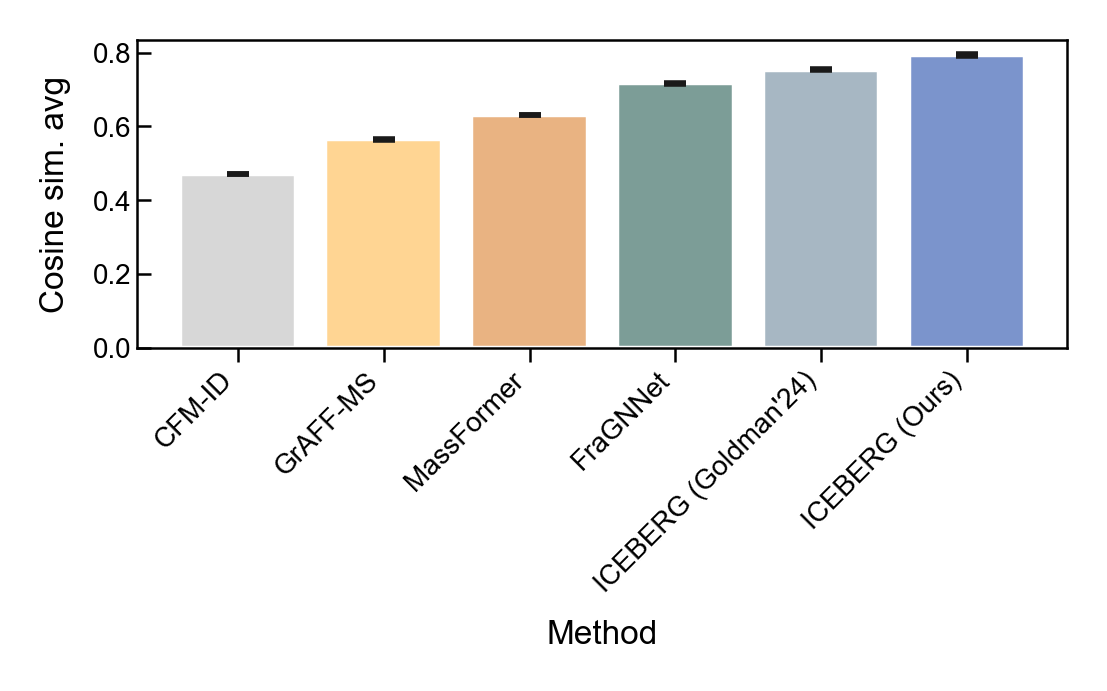

In [14]:
## Define Cosine sim bar plots

dataset = "split_1_nist20"
dataset_sub = out_df[["Method", "Cosine sim. orig", "Cosine sim. 95%", "Dataset"]].query(
    f"Dataset == '{dataset}'"
)
dataset_sub.set_index("Method", inplace=True)
fig = plt.figure(figsize=(3, 1), dpi=400)

ax = fig.gca()
dataset_sub = dataset_sub.loc[names]
sim = dataset_sub[["Cosine sim. orig"]].values.flatten()
errors = dataset_sub[["Cosine sim. 95%"]].values.flatten()
method_names = dataset_sub.index.values

valid_indices = sim > 0

ax.bar(np.array(method_names)[valid_indices], 
       sim[valid_indices], 
       color=np.array([method_colors[i] for i in method_names])[valid_indices], 
    # errors
    yerr=errors[valid_indices],
    # Add style to make them visible
    capsize=2,
    
)

# Add 95% conf bars


ax.set_ylabel("Cosine sim. avg")
ax.set_xlabel("Method")
# Rotate x tick labels
ax.set_xticklabels(np.array(method_names)[valid_indices], rotation=45, ha="right")

In [15]:
adduct_to_display = {
    '[M+H]+': 'of [M$+$H]$^+$',
    '[M-H]-': 'of [M$-$H]$^-$',
    'pos_avg': '\n(positive mode)',
    'neg_avg': '\n(negative mode)',
    'avg': '\n(positive and negative modes)',
    'metfrag': 'of\nMetFrag-supported adducts',
}

/tmp/ipykernel_1430101/2487188266.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.array(method_names)[valid_indices], rotation=45, ha="right", rotation_mode="anchor", fontsize=6)
/tmp/ipykernel_1430101/2487188266.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.array(method_names)[valid_indices], rotation=45, ha="right", rotation_mode="anchor", fontsize=6)


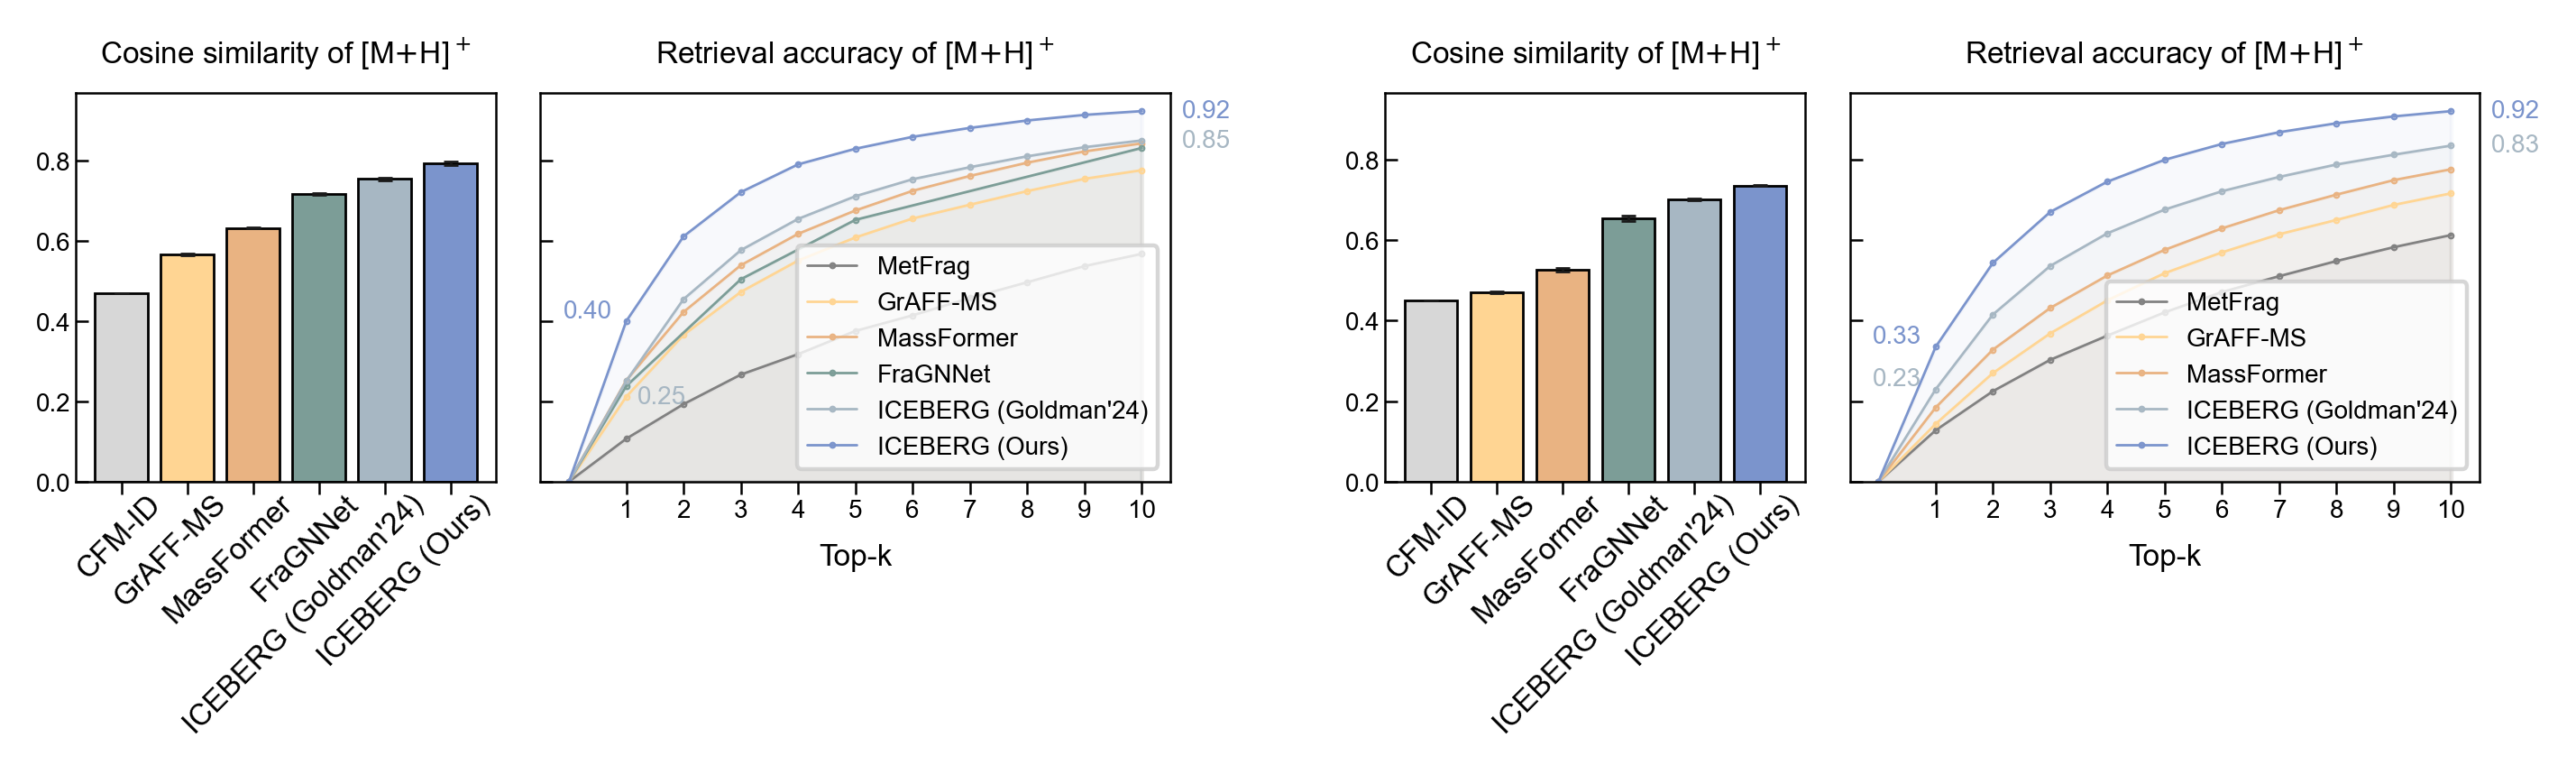

In [16]:
# Plot cosine similarities and time for 2 datasets
# define subplots
gridspec = dict(hspace=0, width_ratios=[1, 1.5, 0.3, 1, 1.5])
fig, axes = plt.subplots(
    1, 5, figsize=(8.6, 1.4), dpi=400, sharey=False, gridspec_kw=gridspec
)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt_dataset_names = {"split_1_nist20": "InChIKey", "scaffold_1_nist20": "Scaffold"}

plot_datasets = [
    "split_1_nist20",
    "scaffold_1_nist20",
]
for ind, (cur_axes, dataset) in enumerate(zip([axes[0:2], axes[3:5]], plot_datasets)):
    # Cosine similarity plot
    ax = cur_axes[0]

    dataset_sub = out_df[
        ["Method", "Cosine sim. orig", "Cosine sim. 95%", "Dataset"]
    ].query(f"Dataset == '{dataset}'")
    dataset_sub.set_index("Method", inplace=True)
    dataset_sub = dataset_sub.loc[names]
    sim = dataset_sub[["Cosine sim. orig"]].values.flatten()
    _sem = dataset_sub[["Cosine sim. 95%"]].values.flatten()

    # Using sem compute 95% confidence interval and plot error bars
    ci = _sem * 1.96

    method_names = dataset_sub.index.values
    
    valid_indices = sim > 0

    ax.bar(
        np.array(method_names)[valid_indices],
        sim[valid_indices],
        color=np.array([method_colors[i] for i in method_names])[valid_indices],
        edgecolor="black",
        linewidth=0.5,
        yerr=ci[valid_indices],
        capsize=1.5,
        error_kw=dict(lw=0.5, capsize=1.5, capthick=0.5),
    )
    ax.set_title(f"Cosine similarity {adduct_to_display[active_adduct]}")
    # ax.set_xlabel("Method")
    # Rotate x tick labels
    ax.set_xticklabels(np.array(method_names)[valid_indices], rotation=45, ha="right", rotation_mode="anchor", fontsize=6)
    dx = 5/72.; dy = 2/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # apply offset transform to all x ticklabels.
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
        
#     ax.set_title(plt_dataset_names.get(dataset))
    ax.yaxis.labelpad = 1
    
    # Retrieval acc plot
    ax = cur_axes[1]
    for method in names:
        sub_df = out_df[
            (out_df["Method"] == method) & (out_df["Dataset"] == dataset)
        ]
        topk, accs, error = [0], [0], [0]
        for i in range(1, 11):
            acc = sub_df[f"Top_{i} Retrieval"].item()
            err = sub_df[f"Top_{i} Retrieval 95%"].item()
            if acc != 0:
                topk.append(i)
                accs.append(acc)
                if err != 0:
                    error.append(err)
        marker = '.'
        if len(accs) > 1:
            ax.plot(
                topk,
                accs,
                color=method_colors[method],
                linewidth=0.5,
                label=method,
                marker=marker,
                markersize=0.8,
            )
            
            ax.legend(fontsize=5)
            
            ax.fill_between(
                topk,
                np.zeros_like(accs),
                np.array(accs),
                alpha=0.05,
                color=method_colors[method],
            )
        
        if method in ['ICEBERG (Ours)', 'ICEBERG (Goldman\'24)']:
            if method == 'ICEBERG (Goldman\'24)' and dataset == 'split_1_nist20':
                ax.text(topk[1]+0.2, accs[1]-0.01, f'{accs[1]:.2f}', 
                        horizontalalignment='left', verticalalignment='top', fontsize=5, color=method_colors[method])
            else:
                ax.text(topk[1]-0.25, accs[1]+0.01, f'{accs[1]:.2f}', 
                        horizontalalignment='right', fontsize=5, color=method_colors[method])
            ax.text(topk[-1]+0.7, accs[-1], f'{accs[-1]:.2f}', 
                    horizontalalignment='left', verticalalignment='center', fontsize=5, color=method_colors[method])
        
#         if len(error) > 1:
#             ax.fill_between(
#                 topk,
#                 np.array(accs) - np.array(error),
#                 np.array(accs) + np.array(error),
#                 alpha=0.2,
#                 color=method_colors[method],
#             )
    ax.xaxis.set_ticks(np.arange(1, 11))
    ax.set_xlabel("Top-k", fontfamily='arial')
    ax.set_title(f"Retrieval accuracy {adduct_to_display[active_adduct]}")

axes[0].get_shared_y_axes().join(axes[0], axes[1])
axes[1].set_xticklabels(list(range(1, 11)))
axes[1].set_yticklabels([])
axes[2].set_visible(False)
axes[3].get_shared_y_axes().join(axes[3], axes[4])
axes[4].set_xticklabels(list(range(1, 11)))
axes[4].set_yticklabels([])


# Save fig to file
fig.savefig(
    results_folder / f"cosine_retrieval_{active_adduct}.pdf", bbox_inches="tight", transparent=True
)

In [17]:
# per-adduct type result for ICEBERG
all_dfs = []
for adduct_type in all_adducts:
    df = adduct_to_df[adduct_type]
    out_df_temp = df[df["Dataset"].isin(["split_1_nist20", "scaffold_1_nist20"])]
    out_df_temp = out_df_temp[out_df_temp["Method"].isin(['ICEBERG (Ours)'])]
    out_df_pivot = out_df_temp.pivot_table(
        index="Method",
        columns="Dataset",
        values=[
            f"Top-{i}" for i in range(1, 11)
        ],
        aggfunc=lambda x: x,
    )
#     out_df_pivot.index.name = 'Adduct type'
    out_df_pivot.rename(index={'ICEBERG (Ours)': adduct_type}, inplace=True)
    all_dfs.append(out_df_pivot)
out_df_pivot = pd.concat(all_dfs, axis=0)
out_df_pivot = out_df_pivot.fillna('-') # fill nan with '-'

out_df_pivot_sorted = out_df_pivot.swaplevel(0, 1, axis=1).round(3)


metric_order = [f"Top-{i}" for i in range(1, 11)]
dataset_order = ["split_1_nist20", "scaffold_1_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", None]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]
out_df_pivot_sorted

out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(
    caption="NIST adduct type retrieavl accuracy",
    label="tab:retrieval_per_adduct",
    escape=False,
)
print(latex)

\begin{table}
\caption{NIST adduct type retrieavl accuracy}
\label{tab:retrieval_per_adduct}
\begin{tabular}{lllllllllllllllllllll}
\toprule
Dataset & \multicolumn{10}{r}{split_1_nist20} & \multicolumn{10}{r}{scaffold_1_nist20} \\
 & Top-1 & Top-2 & Top-3 & Top-4 & Top-5 & Top-6 & Top-7 & Top-8 & Top-9 & Top-10 & Top-1 & Top-2 & Top-3 & Top-4 & Top-5 & Top-6 & Top-7 & Top-8 & Top-9 & Top-10 \\
\midrule
[M+H]+ & $0.400 \pm 0.008$ & $0.611 \pm 0.013$ & $0.721 \pm 0.010$ & $0.790 \pm 0.007$ & $0.829 \pm 0.006$ & $0.859 \pm 0.005$ & $0.881 \pm 0.006$ & $0.900 \pm 0.009$ & $0.913 \pm 0.008$ & $0.923 \pm 0.007$ & $0.335 \pm 0.005$ & $0.543 \pm 0.004$ & $0.669 \pm 0.006$ & $0.745 \pm 0.002$ & $0.799 \pm 0.004$ & $0.838 \pm 0.006$ & $0.867 \pm 0.005$ & $0.890 \pm 0.006$ & $0.907 \pm 0.009$ & $0.920 \pm 0.009$ \\
[M-H2O+H]+ & $0.238 \pm 0.007$ & $0.443 \pm 0.020$ & $0.556 \pm 0.014$ & $0.634 \pm 0.005$ & $0.685 \pm 0.009$ & $0.726 \pm 0.008$ & $0.754 \pm 0.011$ & $0.776 \pm 0.016$ & $0.802 \pm 

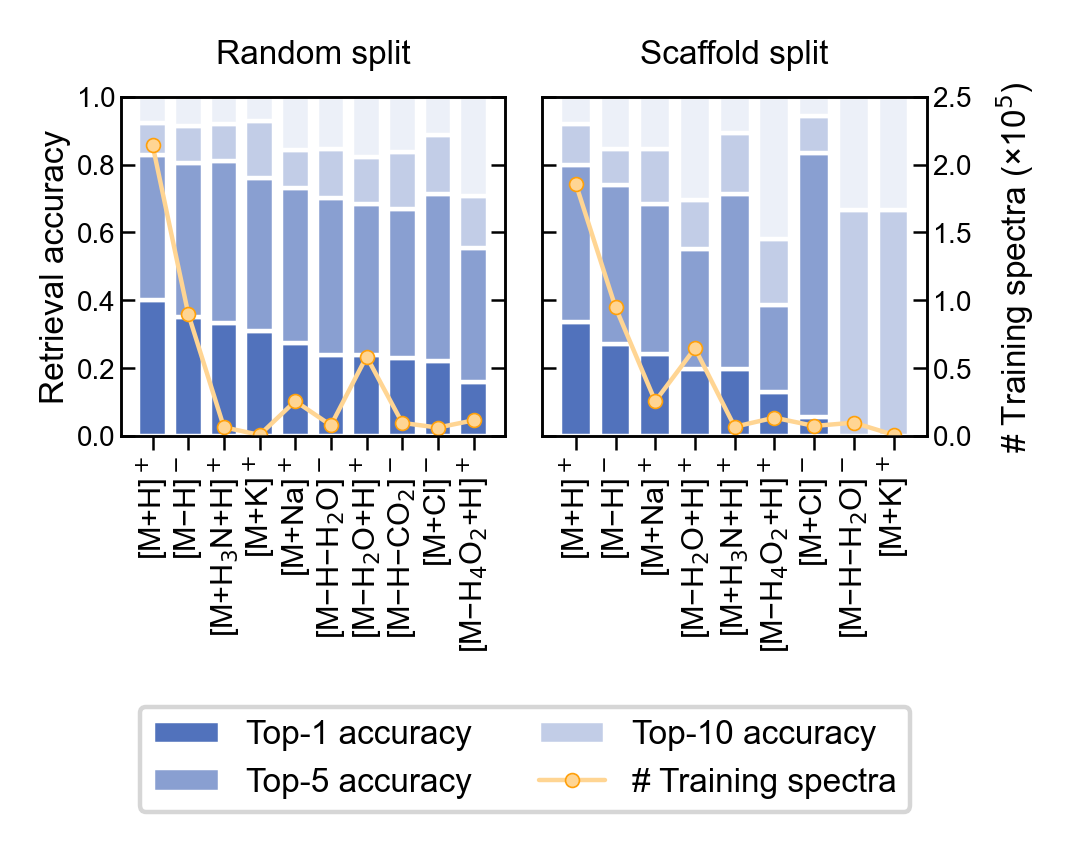

In [18]:
from matplotlib.ticker import ScalarFormatter

# 1) define your training‐size dicts
scaffold_sizes = {
    '[M+H]+': 185847,
    '[M+Na]+': 25460,
    '[M-H2O+H]+': 64581,
    '[M-H]-': 94755,
    '[M-H-H2O]-': 9679,
    '[M-H4O2+H]+': 13344,
    '[M+H3N+H]+': 6626,
    '[M+Cl]-': 7238,
    '[M+K]+': 694,
    '[M-H-CO2]-': 11588
}
random_sizes = {
    '[M+H]+': 214331,
    '[M+Na]+': 25582,
    '[M-H2O+H]+': 58426,
    '[M-H]-': 89875,
    '[M-H-H2O]-': 7720,
    '[M-H4O2+H]+': 11396,
    '[M+H3N+H]+': 6263,
    '[M+Cl]-': 6032,
    '[M+K]+': 622,
    '[M-H-CO2]-': 9504
}

# 2) set up your bar‐plot figure
gridspec = dict(hspace=0.0, width_ratios=[1, -0.15, 1])
fig, axes = plt.subplots(
    1, 3, figsize=(2.6, 1.1), dpi=400, sharey=False, gridspec_kw=gridspec
)
plt_dataset_names = {"split_1_nist20": "Random", "scaffold_1_nist20": "Scaffold"}

plot_datasets = ["split_1_nist20", "scaffold_1_nist20"]

second_axes = []

for ind, (ax, dataset) in enumerate(zip([axes[0], axes[2]], plot_datasets)):
    accs = []
    active_adducts = []
    for adduct_type in all_adducts:
        df = adduct_to_df[adduct_type]
        tmp = df[df["Dataset"] == dataset]
        tmp = tmp[tmp["Method"] == 'ICEBERG (Ours)']
        if not tmp.empty:
            accs.append([
                tmp['Top_1 Retrieval'].item(),
                tmp['Top_5 Retrieval'].item(),
                tmp['Top_10 Retrieval'].item()
            ])
            active_adducts.append(adduct_type)

    # sort by top‐1
    accs = np.array(accs)
    idx = np.argsort(accs[:, 0])[::-1]
    accs = accs[idx]
    active_adducts = np.array(active_adducts)[idx]

    # --- bars ---
    x = np.arange(len(active_adducts))
    ax.bar(x, accs[:, 0], color='#5172bc', label='Top-1 accuracy')
    ax.bar(x, accs[:, 1] - accs[:, 0], bottom=accs[:, 0], color='#899fd1', label='Top-5 accuracy')
    ax.bar(x, accs[:, 2] - accs[:, 1], bottom=accs[:, 1], color='#c2cde7', label='Top-10 accuracy')
    ax.bar(x, 1 - accs[:, 2], bottom=accs[:, 2], color='#ecf0f8')
    ax.set_xticks(x)

    # format adduct labels nicely
    labels = []
    for ad in active_adducts:
        pos = ad.endswith('+')
        s = ad[:-1].replace("2","${_2}$").replace("3","${_3}$").replace("4","${_4}$")\
                    .replace("+","$\mathdefault{+}$").replace("-","$\mathdefault{-}$")
        labels.append(s + ('$^+$' if pos else '$^-$'))
    ax.set_xticklabels(labels, fontsize=5.5, rotation=90)
#     ax.set_xlabel('Adduct type')
    ax.yaxis.labelpad = 1
    ax.set_title(f"{plt_dataset_names[dataset]} split")
    ax.set_ylim(0, 1)

    # --- twin axis for training size ---
    ax2 = ax.twinx()
    train_dict = scaffold_sizes if dataset == 'scaffold_1_nist20' else random_sizes
    sizes = [train_dict[ad] for ad in active_adducts]
    # plot with a marker edge
    line, = ax2.plot(
        x, np.array(sizes) / 1e5,
        marker='o', linestyle='-',
        markersize=2.5,
        linewidth=0.8,
#         color='#E9B382',
#         markeredgecolor='#d17625', markeredgewidth=0.3,
        color='#FFD593',
        markeredgecolor='#ffa00a', markeredgewidth=0.3,
        label='# Training spectra'
    )
    
    second_axes.append(ax2)

axes[0].set_ylabel('Retrieval accuracy')
axes[1].set_visible(False)
axes[0].get_shared_y_axes().join(axes[0], axes[2])
axes[0].set_ylim(0, 1)
axes[2].set_yticklabels([])
second_axes[0].get_shared_y_axes().join(second_axes[0], second_axes[1])
second_axes[0].set_yticklabels([])
second_axes[1].set_ylabel(r'# Training spectra ($\mathdefault{\times 10}^5$)')
second_axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
second_axes[1].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
second_axes[1].set_ylim(0, 2.5)

# 1. grab handles & labels from the bar‐axis (axes[2]) 
bar_h, bar_l = axes[2].get_legend_handles_labels()

# 2. grab handles & labels from the twin‐axis (second_axes[1])
line_h, line_l = second_axes[1].get_legend_handles_labels()

# 3. combine and draw one legend on axes[2]
axes[2].legend(
    bar_h + line_h, 
    bar_l + line_l,
    bbox_to_anchor=(1., -0.75),
    fontsize=6,
    ncol=2
)

fig.savefig(
    results_folder / "retrieval_by_adduct.pdf", bbox_inches="tight", transparent=True
)

In [19]:
# Define mapping for splits
splits = {
    'split_1_nist20': ('Random', random_sizes),
    'scaffold_1_nist20': ('Scaffold', scaffold_sizes)
}

for ds_key, (ds_name, train_dict) in splits.items():
    rows = []
    for adduct_type in all_adducts:
        df = adduct_to_df[adduct_type]
        tmp = df[(df['Dataset'] == ds_key) & (df['Method'] == 'ICEBERG (Ours)')]
        if tmp.empty:
            continue
        rows.append({
            'Adduct': adduct_type,
            'Top-1 Retrieval': tmp['Top_1 Retrieval'].item(),
            'Top-5 Retrieval': tmp['Top_5 Retrieval'].item(),
            'Top-10 Retrieval': tmp['Top_10 Retrieval'].item(),
            'Training Spectra': train_dict[adduct_type],
        })
    table_df = pd.DataFrame(rows)
    table_df = table_df.sort_values('Top-1 Retrieval', ascending=False)
    
    # Print LaTeX table
    print(f"%% LaTeX table: {ds_name} split retrieval accuracies and training sizes")
    print(table_df.to_latex(
        index=False,
        float_format="%.2f",
        caption=f"{ds_name} split retrieval accuracies and training sizes",
        label=f"tab:retrieval_{ds_name.lower()}",
        position="htbp"
    ))

%% LaTeX table: Random split retrieval accuracies and training sizes
\begin{table}[htbp]
\caption{Random split retrieval accuracies and training sizes}
\label{tab:retrieval_random}
\begin{tabular}{lrrrr}
\toprule
Adduct & Top-1 Retrieval & Top-5 Retrieval & Top-10 Retrieval & Training Spectra \\
\midrule
[M+H]+ & 0.40 & 0.83 & 0.92 & 214331 \\
[M-H]- & 0.35 & 0.80 & 0.91 & 89875 \\
[M+H3N+H]+ & 0.33 & 0.81 & 0.92 & 6263 \\
[M+K]+ & 0.31 & 0.76 & 0.93 & 622 \\
[M+Na]+ & 0.27 & 0.73 & 0.84 & 25582 \\
[M-H-H2O]- & 0.24 & 0.70 & 0.85 & 7720 \\
[M-H2O+H]+ & 0.24 & 0.69 & 0.82 & 58426 \\
[M-H-CO2]- & 0.23 & 0.67 & 0.84 & 9504 \\
[M+Cl]- & 0.22 & 0.71 & 0.89 & 6032 \\
[M-H4O2+H]+ & 0.16 & 0.55 & 0.71 & 11396 \\
\bottomrule
\end{tabular}
\end{table}

%% LaTeX table: Scaffold split retrieval accuracies and training sizes
\begin{table}[htbp]
\caption{Scaffold split retrieval accuracies and training sizes}
\label{tab:retrieval_scaffold}
\begin{tabular}{lrrrr}
\toprule
Adduct & Top-1 Retrieval & T

## Retrieval accuracy with number of peaks

In [20]:
dataset_to_res = {}
for dataset_name in dataset_names:
    for split_name in ['split_1', 'scaffold_1']:
        tsv_files = defaultdict(lambda : [])
        for seed in [1,2,3]:    
            retrieval_path_entr = Path(f'results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_npeak_entropy.tsv')
            retrieval_path_cos = Path(f'results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_npeak_cos.tsv')
            if retrieval_path_entr.exists():
                retrieval_df = pd.read_csv(retrieval_path_entr, sep='\t')
            elif retrieval_path_cos.exists():
                retrieval_df = pd.read_csv(retrieval_path_cos, sep='\t')
            else:
                retrieval_df = None

            if retrieval_df is not None:
                retrieval_df = weighted_group_average(retrieval_df)

            tsv_files['ICEBERG (Ours)'].append(retrieval_df)

        dataset_to_res[f"{split_name}_{dataset_name}"] = tsv_files

In [21]:
dataset_to_res

{'split_1_nist20': defaultdict(<function __main__.<lambda>()>,
             {'ICEBERG (Ours)': [  Unnamed: 0  ind_recovered  total_decoys        mass  num_peaks_avg  \
               0     (0, 5]       4.902736     47.674772  242.494287       3.663714   
               1   (10, 15]       4.136292     47.656101  273.654171      12.458734   
               2   (15, 20]       3.775801     47.000000  287.056287      17.518306   
               3   (20, 25]       4.110647     47.686848  305.337005      22.260764   
               4   (25, 30]       3.889362     47.591489  313.063863      27.465529   
               5   (30, 40]       4.216783     47.039960  357.407587      35.167150   
               6  (40, 500]       6.040951     46.203435  415.925817      43.705241   
               7    (5, 10]       4.810345     47.646552  266.970878       7.542925   
               
                  true_dist     top_1     top_2     top_3     top_4     top_5     top_6  \
               0   0.209262  

In [22]:
mass_to_df = {}
for mass_label in ['(0, 5]', '(5, 10]', '(10, 15]', '(15, 20]', '(20, 25]', '(25, 30]', '(30, 40]', '(40, 500]']:
    out_df = []
    for dataset_name, tsv_files in dataset_to_res.items():
        for k, v in tsv_files.items():
            interested_rows = [vv[vv.iloc[:, 0] == mass_label] for vv in v]
            if any([len(row) == 0 for row in interested_rows]):
                continue
            def get_val(key):
                vals = []
                for row in interested_rows:
                    if key in row:
                        vals.append(row[key].item())
                return vals
            new_entry = {
                "Method": k,
                "Cosine sim.": np.mean(get_val('cos_sim')),
                "Cosine sim. 95%": 1.96 * sem(get_val('cos_sim')),

                "Cosine sim. (no PEP)": np.mean(get_val('cos_sim_zero_pep')),
                "Cosine sim. 95% (no PEP)": 1.96 * sem(get_val('cos_sim_zero_pep')),

                "Entropy sim.": np.mean(get_val('entropy_sim')),
                "Entropy sim. 95%": 1.96 * sem(get_val('entropy_sim')),

                "Coverage": np.mean(get_val('coverage')),
                "Coverage 95%": 1.96 * sem(get_val('coverage')),

                # The way of computing validity in this code base is outdated
                #"Valid": np.mean(get_val('frac_valid')),
                #"Valid 95%": 1.96 * sem(get_val('frac_valid')),

                "Dataset": dataset_name,
            }
            new_entry.update({
                f"Top_{i} Retrieval": np.mean(get_val(f"top_{i}")) for i in range(1, 11)
            })
            new_entry.update({
                f"Top_{i} Retrieval 95%": 1.96 * sem(get_val(f"top_{i}")) for i in range(1, 11)
            })
            out_df.append(new_entry)
    out_df = pd.DataFrame(out_df)

    # Replace nan with 0 
    out_df = out_df.fillna(0)
    
    mass_to_df[mass_label] = out_df


/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


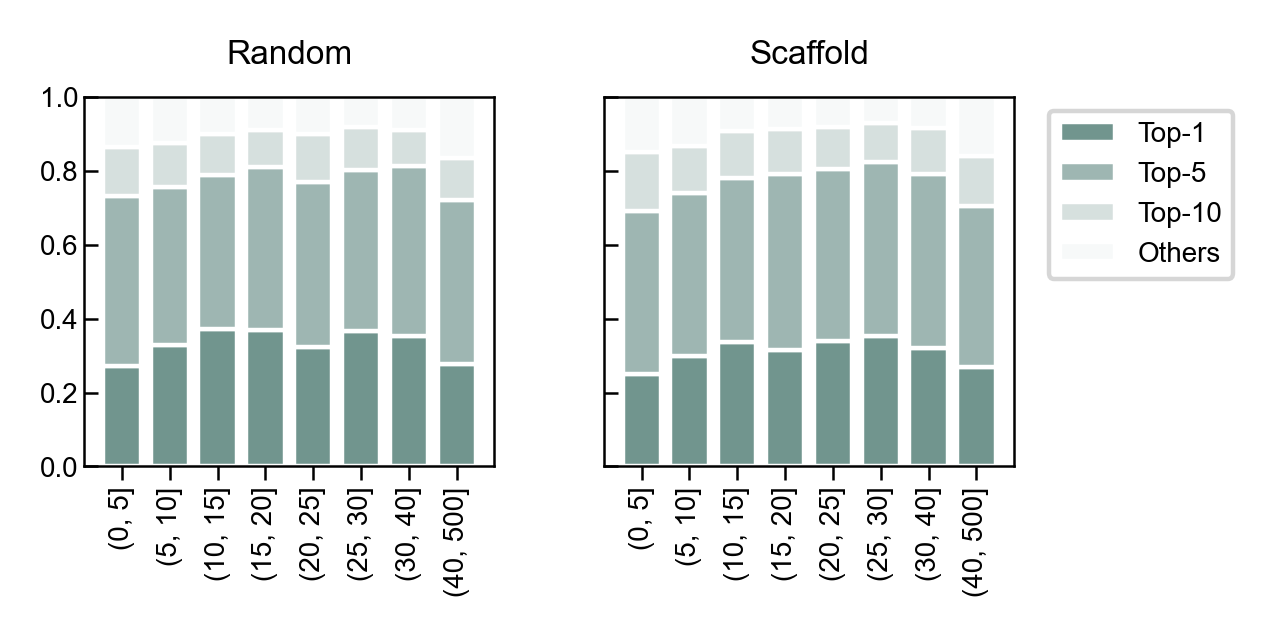

In [23]:
# retrieval accuracy for each adduct type
gridspec = dict(hspace=0.0, width_ratios=[1, 0.00, 1])
fig, axes = plt.subplots(
    1, 3, figsize=(3, 1.2), dpi=400, sharey=False, gridspec_kw=gridspec
)
plt_dataset_names = {"split_1_nist20": "Random", "scaffold_1_nist20": "Scaffold"}

plot_datasets = [
    "split_1_nist20",
    "scaffold_1_nist20",
]

for ind, (ax, dataset) in enumerate(zip([axes[0], axes[2]], plot_datasets)):
    accs = []
    active_adducts = []
    for mass_label in ['(0, 5]', '(5, 10]', '(10, 15]', '(15, 20]', '(20, 25]', '(25, 30]', '(30, 40]', '(40, 500]']:
        df = mass_to_df[mass_label]
        out_df_temp = df[df["Dataset"].isin([dataset])]
        out_df_temp = out_df_temp[out_df_temp["Method"].isin(['ICEBERG (Ours)'])]
        if len(out_df_temp) > 0:
            accs.append([out_df_temp['Top_1 Retrieval'].item(), 
                         out_df_temp['Top_5 Retrieval'].item(), 
                         out_df_temp['Top_10 Retrieval'].item()])
            active_adducts.append(mass_label)
    accs = np.array(accs)
    ax.bar(np.arange(len(active_adducts)), accs[:, 0], bottom=np.zeros(len(active_adducts)), color='#71958e', label='Top-1')
    ax.bar(np.arange(len(active_adducts)), accs[:, 1] - accs[:, 0], bottom=accs[:, 0], color='#9eb6b2', label='Top-5')
    ax.bar(np.arange(len(active_adducts)), accs[:, 2] - accs[:, 1], bottom=accs[:, 1], color='#d6e0de', label='Top-10')
    ax.bar(np.arange(len(active_adducts)), np.ones(len(active_adducts)) - accs[:, 2], bottom=accs[:, 2], color='#f7f9f9', label='Others')
    ax.set_xticks(range(len(active_adducts)))  # Ensure tick positions match the labels
    ax.set_xticklabels(active_adducts, fontsize=5)
    ax.tick_params(axis='x', labelrotation=90)
    ax.yaxis.labelpad = 1
    ax.set_title(plt_dataset_names[dataset])

axes[1].set_visible(False)
axes[0].get_shared_y_axes().join(axes[0], axes[2])
axes[0].set_ylim(0, 1)
axes[2].set_yticklabels([])

plt.legend(bbox_to_anchor=(1.05, 1))

fig.savefig(
    results_folder / "retrieval_by_npeaks.pdf", bbox_inches="tight", transparent=True
)

In [24]:
import yaml

# load yaml
yaml_path = 'results/dag_inten_nist20/split_1_rnd1/retrieval_nist20_split_1_50/rerank_eval_entropy.yaml'
with open(yaml_path) as f:
    data = yaml.safe_load(f)


In [25]:
retrieval_df = pd.DataFrame(data['individuals'])
retrieval_df

,ind_recovered,ion,mass,mass_bin,num_peaks_avg,peak_bin_avg,peak_bin_max,peak_bin_min,spec_name,top_1,...,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,total_decoys,true_dist
0,1.0,[M+H]+,302.060628,300 - 400,35.600000,"(30, 40]","(40, 500]","(5, 10]",nist_1102083,True,...,True,True,True,True,True,True,True,True,50,0.304303
1,1.0,[M+H]+,229.062008,200 - 300,14.428571,"(10, 15]","(20, 25]","(0, 5]",nist_1102232,True,...,True,True,True,True,True,True,True,True,50,0.393764
2,1.0,[M-H2O+H]+,648.341066,600 - 700,35.666667,"(30, 40]","(40, 500]","(5, 10]",nist_1129613,True,...,True,True,True,True,True,True,True,True,50,0.523994
3,1.0,[M+Na]+,648.341066,600 - 700,34.142857,"(30, 40]","(40, 500]","(5, 10]",nist_1129624,True,...,True,True,True,True,True,True,True,True,50,0.427246
4,1.0,[M+H]+,762.185246,700 - 2000,33.071429,"(30, 40]","(40, 500]","(5, 10]",nist_1131501,True,...,True,True,True,True,True,True,True,True,1,0.417144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,48.0,[M+H]+,766.450342,700 - 2000,39.666667,"(30, 40]","(40, 500]","(10, 15]",nist_1291172,False,...,False,False,False,False,False,False,False,False,50,0.875114
4921,48.0,[M-H]-,250.044151,200 - 300,11.000000,"(10, 15]","(15, 20]","(5, 10]",nist_1354368,False,...,False,False,False,False,False,False,False,False,50,0.457010
4922,48.0,[M-H2O+H]+,297.157623,200 - 300,41.700000,"(40, 500]","(40, 500]","(20, 25]",nist_3284125,False,...,False,False,False,False,False,False,False,False,50,0.965187
4923,48.0,[M+Na]+,297.157623,200 - 300,28.800000,"(25, 30]","(40, 500]","(5, 10]",nist_3284188,False,...,False,False,False,False,False,False,False,False,50,0.851680


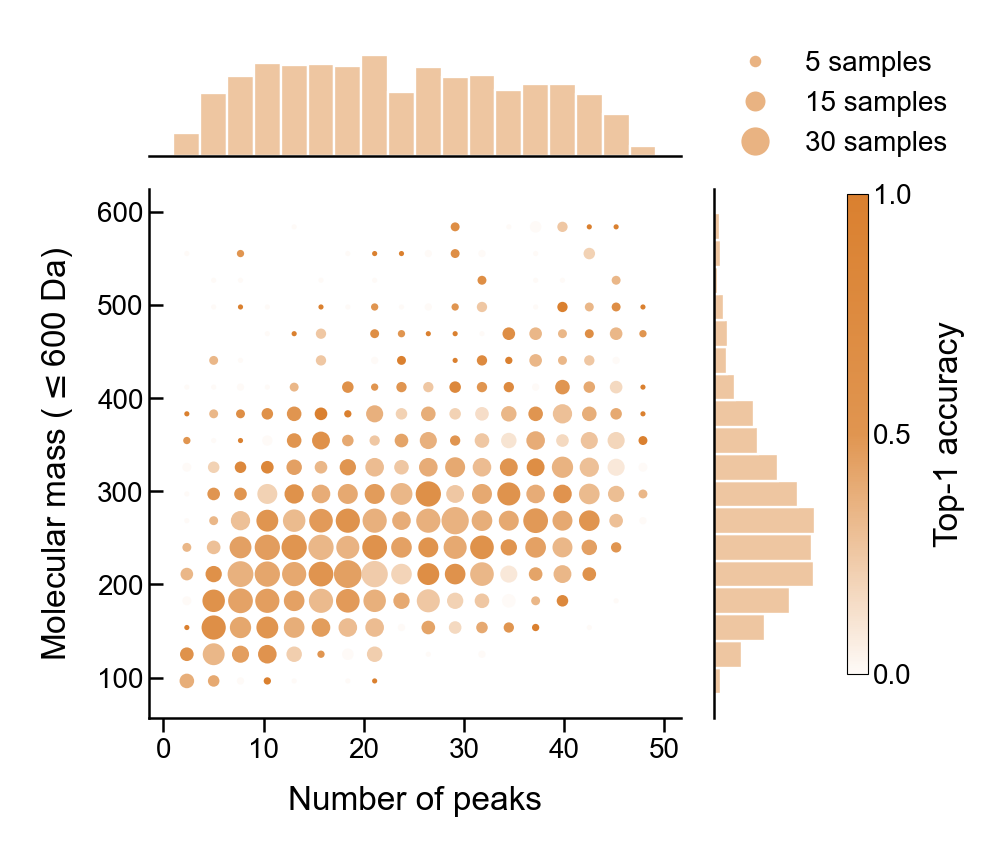

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import binned_statistic_2d

hplus_df = retrieval_df[retrieval_df['ion'] == '[M+H]+']

# Generate sample data
ind_recovered = np.array(hplus_df[hplus_df['mass'] < 600]["ind_recovered"])
num_peaks_avg = np.array(hplus_df[hplus_df['mass'] < 600]["num_peaks_avg"])
mass = np.array(hplus_df[hplus_df['mass'] < 600]["mass"])

left = num_peaks_avg
right = mass
third = ind_recovered

# Define 2D binning
bins = 18
stat_mean, xedges, yedges, binnumber = binned_statistic_2d(
    left, right, third, statistic=lambda x: np.sum(x <= 1) / len(x), bins=bins
)
stat_count, _, _, _ = binned_statistic_2d(
    left, right, None, statistic='count', bins=[xedges, yedges]
)

# Compute bin centers
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2

# Flatten data for scatter plot
x_coords, y_coords = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
mean_flat = stat_mean.flatten()
count_flat = stat_count.flatten()

# Filter out NaNs and zero counts
mask = ~np.isnan(mean_flat) & (count_flat > 0)
x_plot = x_flat[mask]
y_plot = y_flat[mask]
color_plot = mean_flat[mask]
size_plot = count_flat[mask]

# Normalize sizes for better visibility
size_plot_scaled = 25 * (size_plot / size_plot.max())

# Create custom colormap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap', ['#fefaf7', '#e09550', '#da802f'])

# Create figure and GridSpec
fig = plt.figure(figsize=(2.1, 2), dpi=400, constrained_layout=True)
gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.8, 0.2], height_ratios=[0.8, 4], figure=fig)

ax_joint = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)

# Scatter plot
sc = ax_joint.scatter(x_plot, y_plot, s=size_plot_scaled, c=color_plot, cmap=cmap, edgecolor='none')

# Colorbar
cax = fig.add_axes([.98, 0.20, 0.025, 0.60])  # wider (0.025), taller (0.60)
cb = fig.colorbar(sc, cax=cax, ticks=[0, 0.5, 1])
cb.set_label("Top-1 accuracy")
cb.outline.set_linewidth(0.2)
cb.ax.tick_params(size=0)

# Marginal histograms
sns.histplot(x=left, ax=ax_marg_x, bins=bins, color="#e9b382")
sns.histplot(y=right, ax=ax_marg_y, bins=bins, color="#e9b382")

# Turn off ticks for marginals
ax_marg_x.tick_params(axis='x', labelbottom=False)
ax_marg_y.tick_params(axis='y', labelleft=False)

# Remove top and right spines from joint plot
ax_joint.spines['top'].set_visible(False)
ax_joint.spines['right'].set_visible(False)

# Clean up marginal spines
for spine in ['top', 'right', 'left']:
    ax_marg_x.spines[spine].set_visible(False)
for spine in ['top', 'right', 'bottom']:
    ax_marg_y.spines[spine].set_visible(False)
    
# Hide labels
ax_marg_x.set_ylabel("")
ax_marg_y.set_xlabel("")

# Turn off ticks for marginals
ax_marg_x.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax_marg_y.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

# Axis labels and title
ax_joint.set_xlabel("Number of peaks")
ax_joint.set_ylabel("Molecular mass ($\leq$600 Da)")

from matplotlib.lines import Line2D

# Create example sizes for legend
example_counts = [5, 15, 30] 
example_sizes = 25 * (np.array(example_counts) / size_plot.max())

# Create dummy scatter points
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'{int(count)} samples',
           markerfacecolor='#e9b382', markersize=np.sqrt(size), markeredgecolor='none')
    for count, size in zip(example_counts, example_sizes)
]

fig.legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1.13, 1.01),
    frameon=False,
)


plt.show()
fig.savefig(
    results_folder / "npeaks_mass_top1.pdf", bbox_inches="tight", transparent=True
)

In [27]:
# Generate tables for deatiled statistics
# Create bin labels
x_labels = ['{' + f"[{xedges[i]:.1f}, {xedges[i+1]:.1f}" + (")" if i != len(xedges)-2 else "]") + '}' for i in range(len(xedges)-1)]
y_labels = ['{' + f"[{yedges[j]:.0f}, {yedges[j+1]:.0f}" + (")" if j != len(yedges)-2 else "]") + '}' for j in range(len(yedges)-1)]

# Construct DataFrames
df_count = pd.DataFrame(stat_count.astype(int), index=x_labels, columns=y_labels)
df_acc = pd.DataFrame(stat_mean, index=x_labels, columns=y_labels)
df_acc = df_acc.fillna('-')

# Generate LaTeX tables
latex_count = df_count.to_latex(
    index=True, 
    caption="Number of samples per bin", 
    label="tab:samples",
    position="htbp"
)

latex_acc = df_acc.to_latex(
    float_format="%.2f",
    index=True,
    caption="Top-1 accuracy per bin",
    label="tab:accuracy",
    position="htbp"
)

print("%% LaTeX table: Number of samples in each bin")
print(latex_count)
print("%% LaTeX table: Top-1 accuracy in each bin")
print(latex_acc)

%% LaTeX table: Number of samples in each bin
\begin{table}[htbp]
\caption{Number of samples per bin}
\label{tab:samples}
\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
 & {[82, 111)} & {[111, 139)} & {[139, 168)} & {[168, 197)} & {[197, 225)} & {[225, 254)} & {[254, 283)} & {[283, 311)} & {[311, 340)} & {[340, 369)} & {[369, 397)} & {[397, 426)} & {[426, 455)} & {[455, 484)} & {[484, 512)} & {[512, 541)} & {[541, 570)} & {[570, 598]} \\
\midrule
{[1.0, 3.7)} & 8 & 7 & 1 & 3 & 6 & 3 & 1 & 1 & 3 & 2 & 1 & 1 & 0 & 0 & 0 & 0 & 1 & 0 \\
{[3.7, 6.4)} & 5 & 18 & 22 & 19 & 10 & 7 & 3 & 6 & 5 & 1 & 3 & 1 & 3 & 0 & 1 & 1 & 0 & 0 \\
{[6.4, 9.0)} & 2 & 11 & 17 & 23 & 25 & 18 & 14 & 6 & 5 & 1 & 3 & 2 & 1 & 0 & 1 & 1 & 2 & 0 \\
{[9.0, 11.7)} & 2 & 13 & 18 & 22 & 24 & 24 & 18 & 15 & 6 & 4 & 5 & 1 & 0 & 1 & 1 & 0 & 0 & 0 \\
{[11.7, 14.4)} & 1 & 9 & 16 & 16 & 22 & 24 & 19 & 14 & 9 & 8 & 8 & 3 & 0 & 1 & 0 & 0 & 0 & 1 \\
{[14.4, 17.1)} & 0 & 2 & 13 & 22 & 23 & 24 & 21 & 13 & 6 & 12 & 6 & 0 & 4 & 4 & 1 & 

/tmp/ipykernel_1430101/2263705340.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


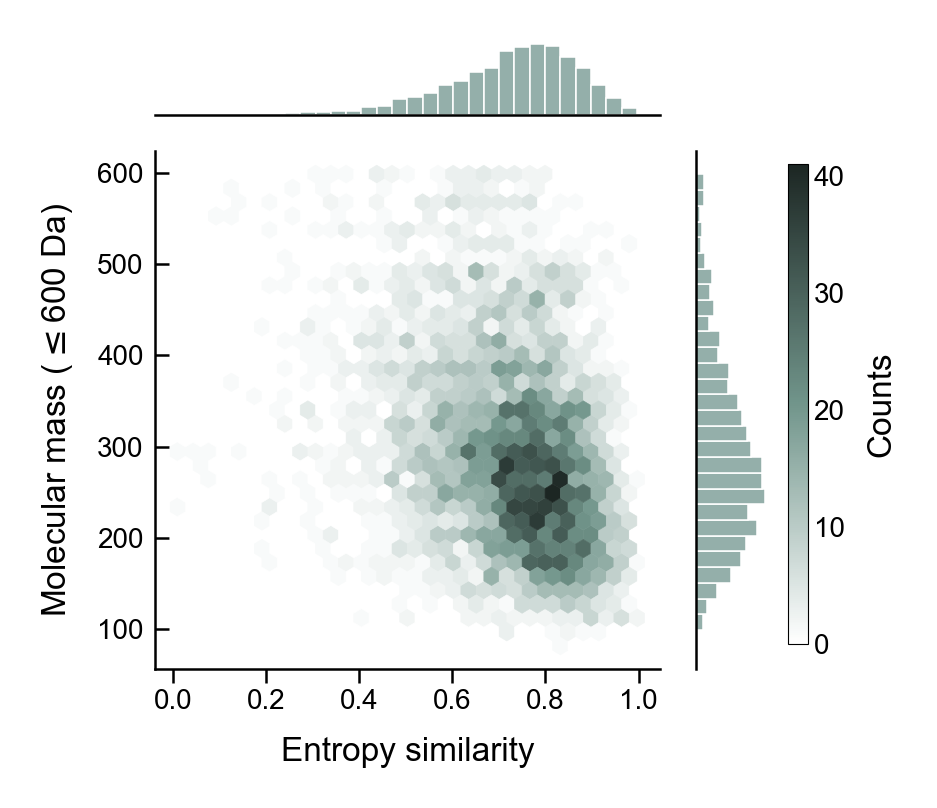

In [28]:
import matplotlib.ticker as ticker


sns.set_theme(rc={'figure.figsize': (2.1, 2.), 
                  'figure.dpi': 400, 
                  'axes.edgecolor': 'black',
                  'axes.labelcolor': 'black',
                  'text.color': 'black',
                  'xtick.color': 'black',
                  'ytick.color': 'black'}, style="white", font="Arial")
set_style() # prevent the style from being modified by seaborn

retrieval_df["true_sim"] = 1 - retrieval_df["true_dist"] # distance to similarity

# g = sns.jointplot(
#     data=retrieval_df[retrieval_df['mass'] < 600],
#     x="true_sim",
#     y="mass",
#     kind="hex",
#     color="#71958e",
#     marginal_kws=dict(bins=30)
# )

g = sns.JointGrid(
    data=retrieval_df[retrieval_df['mass'] < 600],
    x="true_sim",
    y="mass",
    marginal_ticks=True,
    space=0,
    height=2.,
)

# Plot the hexbin manually without edge lines
hb = g.ax_joint.hexbin(
    retrieval_df[retrieval_df['mass'] < 600]['true_sim'],
    retrieval_df[retrieval_df['mass'] < 600]['mass'],
    gridsize=30,
    cmap=matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap', ['#ffffff', '#71958b', '#1c2623']),
    linewidths=0.1  # removes edgewidth
)

# Add colorbar
cax = g.figure.add_axes([.98, 0.20, 0.025, 0.60])  # wider (0.025), taller (0.60)
cb = g.figure.colorbar(hb, cax=cax, ticks=[0, 10, 20, 30, 40])
cb.set_label("Counts")
cb.outline.set_linewidth(0.2)
cb.ax.tick_params(size=0)

# Add marginal histograms
sns.histplot(
    data=retrieval_df[retrieval_df['mass'] < 600],
    x="true_sim",
    ax=g.ax_marg_x,
    bins=30,
    color="#71958e"
)
sns.histplot(
    data=retrieval_df[retrieval_df['mass'] < 600],
    y="mass",
    ax=g.ax_marg_y,
    bins=30,
    color="#71958e"
)

# Clean up marginal spines
for spine in ['top', 'right', 'left']:
    g.ax_marg_x.spines[spine].set_visible(False)
for spine in ['top', 'right', 'bottom']:
    g.ax_marg_y.spines[spine].set_visible(False)

# Hide labels
g.ax_marg_x.set_ylabel("")
g.ax_marg_y.set_xlabel("")

# Turn off ticks for marginals
g.ax_marg_x.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
g.ax_marg_y.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)


g.ax_joint.tick_params(left=True, bottom=True)
g.ax_joint.tick_params(axis="y",direction="in", pad=2)

# Set axis labels
g.ax_joint.set_xlabel("Entropy similarity", fontsize=6)
g.ax_joint.set_ylabel("Molecular mass ($\leq$600 Da)", fontsize=6)

plt.tight_layout()
plt.show()
g.savefig(
    results_folder / "mass_entropy.pdf", bbox_inches="tight", transparent=True
)

In [29]:
# get hexagon plot raw data
import pandas as pd

# 1) Grab the counts and the (x,y) centers of each occupied hex‐bin
counts  = hb.get_array().astype(int)
centers = hb.get_offsets()     # shape (N,2): [true_sim_center, mass_center]

# 2) Pack into a DataFrame
df_raw = pd.DataFrame({
    'Entropy_Similarity_Center': centers[:, 0],
    'Mass_Center':              centers[:, 1],
    'Count':                    counts
})

# 3) Print as a LaTeX table
print(df_raw.to_latex(
    index=False,
    float_format="%.3f",
    caption="Raw hexbin counts per bin",
    label="tab:raw_hexbin_counts",
    position="htbp"
))

\begin{table}[htbp]
\caption{Raw hexbin counts per bin}
\label{tab:raw_hexbin_counts}
\begin{tabular}{rrr}
\toprule
Entropy_Similarity_Center & Mass_Center & Count \\
\midrule
0.011 & 82.053 & 0 \\
0.011 & 112.415 & 0 \\
0.011 & 142.777 & 0 \\
0.011 & 173.139 & 0 \\
0.011 & 203.501 & 0 \\
0.011 & 233.862 & 1 \\
0.011 & 264.224 & 0 \\
0.011 & 294.586 & 1 \\
0.011 & 324.948 & 0 \\
0.011 & 355.310 & 0 \\
0.011 & 385.672 & 0 \\
0.011 & 416.034 & 0 \\
0.011 & 446.396 & 0 \\
0.011 & 476.758 & 0 \\
0.011 & 507.119 & 0 \\
0.011 & 537.481 & 0 \\
0.011 & 567.843 & 0 \\
0.011 & 598.205 & 0 \\
0.044 & 82.053 & 0 \\
0.044 & 112.415 & 0 \\
0.044 & 142.777 & 0 \\
0.044 & 173.139 & 0 \\
0.044 & 203.501 & 0 \\
0.044 & 233.862 & 0 \\
0.044 & 264.224 & 0 \\
0.044 & 294.586 & 1 \\
0.044 & 324.948 & 0 \\
0.044 & 355.310 & 0 \\
0.044 & 385.672 & 0 \\
0.044 & 416.034 & 0 \\
0.044 & 446.396 & 0 \\
0.044 & 476.758 & 0 \\
0.044 & 507.119 & 0 \\
0.044 & 537.481 & 0 \\
0.044 & 567.843 & 0 \\
0.044 & 598.205 & 0 \